Used the Kaggle competition as the example https://www.kaggle.com/jake126/face-detection-using-cnn-with-the-lfw-dataset

# 1. Library installation and data read-in

In [6]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [7]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
import tensorflow as tf
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

# dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

In [8]:
data_name = 'lfw-deepfunneled'
base_url = 'http://vis-www.cs.umass.edu/lfw/'
data_file = data_name + '.tgz'
data_dir = tf.keras.utils.get_file(
    fname=data_name, 
    origin=base_url + data_file,
    untar=True)

108765184/108761145 [==============================] - 3s 0us/step


In [0]:
import tarfile
tar = tarfile.open('/content/input/lfw-deepfunneled.tgz', 'r')
tar.extractall()
tar.extractall(r'/content/input')

In [0]:
!mkdir -p /content/input/lfw-dataset
# copy csv files into /content/input/lfw-dataset directory

In [0]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("/content/input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("/content/input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("/content/input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("/content/input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("/content/input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/input/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("/content/input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("/content/input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("/content/input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [25]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


A summary of the available files follows below:

**lfw_allnames.csv**: a CSV containing two columns; name (a list of all names in the entire dataset) and images (the number of images available for the each name) <br/>
**matchpairsDevTest**: a random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels <br/>
**matchpairsDevTrain**: a random sample of 1100 image pairs featuring the same individual, with columns for the name and the image labels <br/>
**mismatchpairsDevTest**: a random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**mismatchpairsDevTrain**: a random sample of 1100 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**pairs.csv**: 6000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formating, these two sets of rows will be split into matched_pairs and unmatched_pairs data frames <br/>
**people.csv**: list of names and image counts, identical to lfw_allnames.csv once null values have been removed. Omit from further analysis <br/>
**peopleDevTest.csv**: 1711 individuals in the dataset designed for testing: columns for celebrity name and image count (zero overlap with peopleDevTrain.csv) <br/>
**peopleDevTrain.csv**: 4038 individuals in the dataset designed for training: columns for celebrity name and image count (zero overlap with peopleDevTest.csv) <br/>

In addition, we have a catalogue of deepfunneled LFW images, created by Gary B. Huang, Marwan Mattar, Honglak Lee, and Erik Learned-Miller (details [here](http://vis-www.cs.umass.edu/papers/nips2012_deep_congealing.pdf)). This is the most useful dataset created by the LFW team, as the images have been rotated and sized to ensure consistent alignment prior to analysis, leading to stronger results when image recognition algorithms are applied to the dataset. 

### Data reshaping and train/test split

We need to define the objective more clearly before we create the train/test split. What are we trying to achieve with this project?<br/>

The flow of the project should be as follows: <br/>
1. Build a model on the training data that can predict the names associated with images. <br/>
The training set should incorporate multiple images of some individuals, to equip the model with knowledge of how to deal with the same face in different situations.
2. Test the model on new images and predict the identity <br/>
The test set needs to incorporate some individuals that we have seen in the training set (although not the same images) and some individuals that we haven't, to test the algorithm's accuracy.

Therefore, we need to split the data into training and test data.

In [26]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

836
855


### Image format exploration

In [29]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "/content/input/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance:

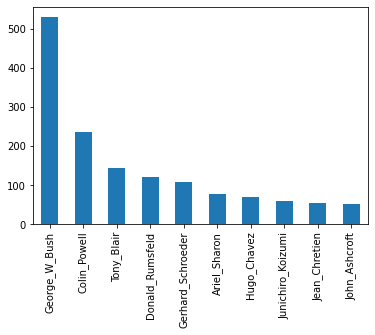

In [30]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

We can see that there are some very well-represented figures among the top 10: generally political and generally male. This has important implications for the usefulness of this dataset in generalizations, which we consider in the conclusion. To draw this further into distinction, how many individuals are represented by a single image, compared to George W Bush's 530? 

In [31]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

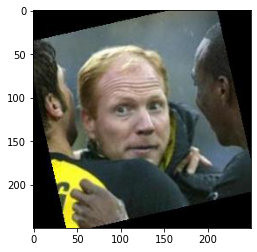

In [32]:
im = Image.open("/content/input/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

# 4. Model Construction
## 4. a. Preliminary Model: Detecting Faces
Any model concerned with classifying faces is posed with a preliminary problem: what is meant by a 'face'? This is obviously trivial for humans but identifying a face in an image is non-trivial for an image recognition algorithm. In the LFW data set, the data has been pre-processed to ensure that faces occupy a similar portion of each image, and that they are aligned consistently, with images rotated so the faces are square with the camera. Furthermore, the main CNN model we encode below considers the whole image, so implicitly recognises features of a face without us having to state where the face is. Thus, face detection is less important in this situation. However, in the real world - and particularly if we extend CNN analysis to videos - images are unlikely to be organised so helpfully, and this processing step is likely to be very important, hence its inclusion in this notebook. <br/>

To do this, we leverage previous work in the field. Facial detection is a well-researched area, and there are many potential methods to investigate and pre-trained models that perform well at identifying the region and features of a face. The model we focus on, MTCNN (Multitask Cascaded Convolutional Neural Networks) is optimised to identify the area of an image occupied by a face as well as the location of the eyes, nose, and mouth. The mechanics of this are detailed [here](http://arxiv.org/abs/1604.02878). At a high level, the model leverages three distinct deep convolutional layers to target and model the features of a face, with the layers constructed in a way that specifically addresses the challenges associated with facial images such as inconsistent orientation, shadows or obstructions, and inconsistent shapes between e.g. an open and closed mouth. <br/>

As well as strong performance evaluation on other face datasets, MTCNN has the added benefit of being very fast and very straightforward to implement, as is demonstrated in the below code cell:

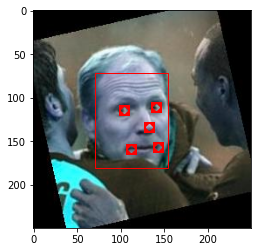

In [34]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("/content/input/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

We don't use these features in the main CNN models below, but they would be useful feature inputs for future models.

## 4. b. Classifying Faces: CNN Approach on a Simplified Dataset
In this Section we will implement a classic CNN algorithm on the LFW dataset. Before we build any models, it is important to understand the structure and purpose of a CNN. There is a wealth of literature available, but the main themes are briefly synthesised below.

A Convolutional Neural Network (CNN) is a neural network used primarily for image analysis. Its primary insight is that image regions can be scanned to obtain lower-dimensional "convolved" representations that preserve the relationships between pixel areas. There are 4 key steps in a CNN:

1. **Convolution**: convolve the images using a feature detector to obtain a feature map (e.g. edge detection)
2. **Non-Linearity**: create non-linearities in the data using a non-linear activation function
3. **Pooling**: reduce dimension of the feature maps further by considering average convolved values in a region
4. **Connect the layers**: organise all previous aspects of the model into a fully connected network that can be used to generate model predictions

The network is then trained using back-propagation.

Traditional CNN works best when the classes are balanced, and when the classification method is binary, i.e. we are testing to see whether the images are in category A or B. We can recreate these conditions on a subset of the data, using the most well-sampled individual: George W Bush. The goal of this first-pass CNN is to identify whether an image is George W Bush or not; we use a random sample of the other images for category B. 

In [0]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [0]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
# It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [0]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [0]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels. 

In [0]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/input/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/input/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/input/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/input/working/',dir_name,data_type))
        path_from = os.path.join('/content/input/lfw-deepfunneled/',image)
        path_to = os.path.join('/content/input/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [0]:
!mkdir -p /content/input/working/

In [46]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


Now all the images are in the relevant training/test folders, we can run our CNN algorithm.

In [47]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                      shear_range = 0.2,
                                                      zoom_range = 0.2,
                                                      horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('/content/input/working/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('/content/input/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('/content/input/working/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [48]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678,
                                             # to limit runtime restrict the maximum epoch number
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/8
678/678 [==============================] - 1432s 2s/step - loss: 0.5543 - accuracy: 0.8642 - val_loss: 0.7221 - val_accuracy: 0.8992
Epoch 2/8
678/678 [==============================] - 1446s 2s/step - loss: 0.0892 - accuracy: 0.9655 - val_loss: 0.1702 - val_accuracy: 0.9352
Epoch 3/8
678/678 [==============================] - 1433s 2s/step - loss: 0.0717 - accuracy: 0.9742 - val_loss: 0.0020 - val_accuracy: 0.9165
Epoch 4/8
678/678 [==============================] - 1433s 2s/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.9404 - val_accuracy: 0.8820
Epoch 5/8
678/678 [==============================] - 1438s 2s/step - loss: 0.0779 - accuracy: 0.9724 - val_loss: 0.1353 - val_accuracy: 0.9239
Epoch 6/8
678/678 [==============================] - 1437s 2s/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.3689 - val_accuracy: 0.9582
Epoch 7/8
678/678 [==============================] - 1433s 2s/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 2.4893 - val_accuracy: 0.9294

Now that the model is operational, we can look at the relationship between the training and validation loss to see if overfitting is likely to have taken place:

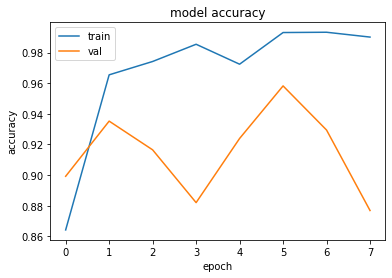

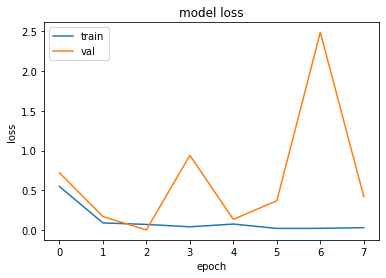

In [49]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Given the relatively low number of epochs, the model still appears to be converging - the validation loss/accuracy is instable, which is also a function of the validation method (in future iterations, cross validation would be a preferable method). However, accuracy is generally high on both sets, indicating that the model is performing well. To confirm the model's performance, we look at the precision and recall on the (unseen) test set, comparing accuracy with the true labels:

In [0]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [0]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [0]:
# Compute predictions
Bush_predictions_0 = predictions("/content/input/working/Bush_test/"+ Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("/content/input/working/Bush_test/"+ Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

In [0]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [54]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Precision:[0.8125, 0.89]
Recall:[0.8921568627450981, 0.8090909090909091]
['George_W_Bush', 'not_George']


The meaning of these results will be considered further in the conclusion. Before proceding, we clear the workspace to ensure the Kernel can successfully run in the Kaggle infrastructure:

In [0]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")


## 4. c. Classifying Faces: Multiple Classes Using a Classic CNN
The immediate logical extension of this problem is to extend analysis to multiple classes. With enough time, we could exactly replicate this approach on the entire dataset, using every identity as a separate class. However, given time constraints, we can consider a brief extension to explore the strengths and limitations of a simple CNN model. Instead of taking Bush and non-Bush images, we will take an arbitrary cut-off of the 6 most frequently occurring celebrities and attempt to classify the images.

In [56]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

There is a clear issue with class imbalance here: to ensure more balanced classes, we could up-sample some of the low-representation individuals, but in the interests of algorithmic speed we will instead down-sample the high-representation individuals:

In [0]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

We then run the model as before, adjusting for multiple classes:

In [58]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are training on several classes, we need several classification units (one for each class). We also use a 
# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                  shear_range = 0.2,
                                                  zoom_range = 0.2,
                                                  horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/content/input/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/content/input/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/content/input/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')


multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 288,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 14,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Epoch 1/14
288/288 [==============================] - 631s 2s/step - loss: 1.2095 - accuracy: 0.6802 - val_loss: 2.2605 - val_accuracy: 0.6667
Epoch 2/14
288/288 [==============================] - 628s 2s/step - loss: 0.0757 - accuracy: 0.9831 - val_loss: 0.9926 - val_accuracy: 0.7778
Epoch 3/14
288/288 [==============================] - 630s 2s/step - loss: 0.0412 - accuracy: 0.9907 - val_loss: 0.3964 - val_accuracy: 0.7500
Epoch 4/14
288/288 [==============================] - 629s 2s/step - loss: 0.0149 - accuracy: 0.9971 - val_loss: 1.5692 - val_accuracy: 0.7917
Epoch 5/14
288/288 [==============================] - 628s 2s/step - loss: 0.0113 - accuracy: 0.9976 - val_loss: 2.2283 - val_accuracy: 0.7917
Epoch 6/14
288/288 [==========================

Again, it is useful to check for convergence:

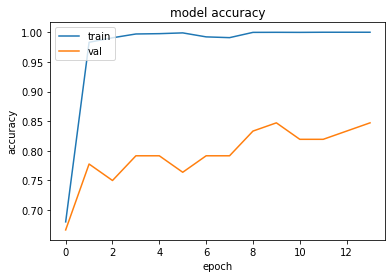

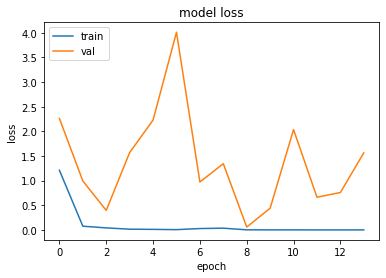

In [59]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

More than 14 epochs are needed.

In [0]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [0]:
multi_predictions_0 = predictions("/content/input/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/content/input/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/content/input/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/content/input/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/content/input/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/content/input/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


In [0]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [63]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0.9230769230769231, 1.0, 0.6521739130434783, 0.7857142857142857, 1.0, 0.4230769230769231]
Recall:[0.631578947368421, 0.5, 0.8823529411764706, 0.5789473684210527, 0.7272727272727273, 0.9166666666666666]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


In [0]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")